In [1]:
# libraries
import pandas as pd 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline 
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
#read in data from csv
corpus=pd.read_csv("/content/drive/MyDrive/cleaned_corpus.csv",  usecols=['Country', 'Placing_clean', 'artist', 'title', 'clean_lyrics_nostop']
                   )

corpus.head()


,Country,Placing_clean,artist,title,clean_lyrics_nostop
0,Finland,DNQ,Jari Sillanpää,Takes 2 To Tango,time leave time feel harp horn musics born two...
1,Belarus,DNQ,Aleksandra & Konstantin,My Galileo,stay home heady quest venture mode road tread ...
2,Malta,12,Julie & Ludwig,On Again... Off Again,look need attention girl serious intention lik...
3,Greece,3,Sakis Rouvas,Shake It,every time wanna play turn way come take ride ...
4,Lithuania,DNQ,Linas & Simona,What Happened To Your Love,whats happened love whats happened love weve t...


# NLP Task 1: Sentiment Analysis

In [ ]:
sent_corpus=corpus

# calculate sentiment polarity scores for song lyrics
sent_corpus['sentiment'] = corpus.apply(lambda r: sid.polarity_scores(r.clean_lyrics_nostop), axis=1)


# create compoound score
sent_corpus['compound']  = corpus['sentiment'].apply(lambda score_dict: score_dict['compound'])

# create positive score
sent_corpus['positive']  = corpus['sentiment'].apply(lambda score_dict: score_dict['pos']) 
# create negative score
sent_corpus['negative']  = corpus['sentiment'].apply(lambda score_dict: score_dict['neg'])
# create neutral score
sent_corpus['neutral']  = corpus['sentiment'].apply(lambda score_dict: score_dict['neu'])
# create classes for compound score- positive, negative or neutral 
sent_corpus['comp_score'] = corpus['compound'].apply(lambda c: 'pos' if c  >=0.05 else('neg' if  c <= - 0.05 else 'neutral'))


sent_corpus.head() 

,Country,Placing_clean,artist,title,clean_lyrics_nostop,sentiment,positive,negative,neutral,compound,comp_score
0,Finland,DNQ,Jari Sillanpää,Takes 2 To Tango,time leave time feel harp horn musics born two...,"{'neg': 0.096, 'neu': 0.596, 'pos': 0.308, 'co...",0.308,0.096,0.596,0.9924,pos
1,Belarus,DNQ,Aleksandra & Konstantin,My Galileo,stay home heady quest venture mode road tread ...,"{'neg': 0.077, 'neu': 0.886, 'pos': 0.037, 'co...",0.037,0.077,0.886,-0.5267,neg
2,Malta,12,Julie & Ludwig,On Again... Off Again,look need attention girl serious intention lik...,"{'neg': 0.017, 'neu': 0.556, 'pos': 0.427, 'co...",0.427,0.017,0.556,0.9980,pos
3,Greece,3,Sakis Rouvas,Shake It,every time wanna play turn way come take ride ...,"{'neg': 0.423, 'neu': 0.239, 'pos': 0.339, 'co...",0.339,0.423,0.239,0.9802,pos
4,Lithuania,DNQ,Linas & Simona,What Happened To Your Love,whats happened love whats happened love weve t...,"{'neg': 0.026, 'neu': 0.566, 'pos': 0.408, 'co...",0.408,0.026,0.566,0.9971,pos


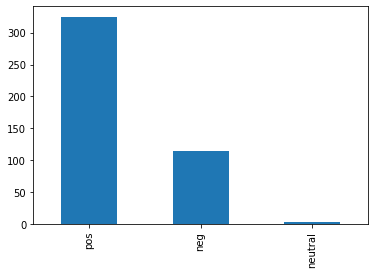

In [ ]:
# look at distribution of compound scores
fig, ax = plt.subplots()
corpus['comp_score'].value_counts().plot(ax=ax, kind='bar')

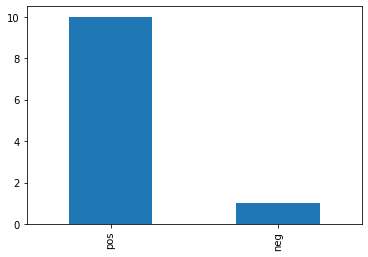

In [ ]:
# look at sentiment distribution of winners
winners = corpus.loc[corpus['Placing_clean'] =='1']
fig, ax = plt.subplots()
winners['comp_score'].value_counts().plot(ax=ax, kind='bar')

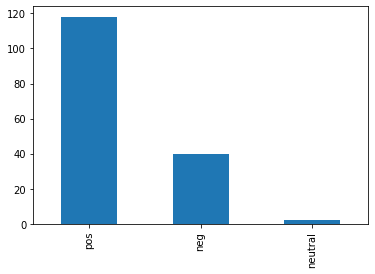

In [ ]:
# look at sentiment distribution of DNQ
DNQ = corpus.loc[corpus['Placing_clean'] =='DNQ']
fig, ax = plt.subplots()
DNQ['comp_score'].value_counts().plot(ax=ax, kind='bar')


In [ ]:
# create labels song placings in the competition- winner, DNQ or finalist
sent_corpus['y']=sent_corpus['Placing_clean'].apply(lambda c: 'winner' if c  =='1' else('DNQ' if  c =='DNQ'  else 'finalist'))


In [ ]:
# Creating test and train split to be able to train a model to predict song placing  which is 'y' based on the setiment polarity scores for the song lyrics 

X= sent_corpus[['positive',	'negative',	'neutral']]	

X_train, X_test, y_train, y_test = train_test_split(X, sent_corpus['y'], test_size=0.3,random_state=109) # 70% training and 30% test



In [ ]:
#Create a svm Classifier
clf = svm.SVC(decision_function_shape='ovo') # one vs one classifier 

#Train the model using the training sets of sentiment polarity scores
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
# look at the accuracy of the results for the test data
print(f"Test Set Accuracy : {accuracy_score(y_test, y_pred) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report( y_test, y_pred)}")

Test Set Accuracy : 60.150375939849624 %


Classification Report : 

              precision    recall  f1-score   support

         DNQ       0.00      0.00      0.00        49
    finalist       0.60      1.00      0.75        80
      winner       0.00      0.00      0.00         4

    accuracy                           0.60       133
   macro avg       0.20      0.33      0.25       133
weighted avg       0.36      0.60      0.45       133



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NLP Task 2: Topic Modelling

In [3]:
# lyric tokenisation

lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in corpus['clean_lyrics_nostop']:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)



In [4]:
# remove tokens with less than 3 characters- likely musical oh's and ah's
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []    
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

In [5]:
# token lemmenatization

lemmatizer = WordNetLemmatizer()
for s,song in enumerate(lyric_corpus_tokenized):
    lemmatized_tokens = []
    for token in song:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    lyric_corpus_tokenized[s] = lemmatized_tokens

In [6]:
# make a dictionary of lemmatised words 

dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8) # get rid of words in >80% songs

In [52]:
#Bag-of-Words and Index to Dictionary Conversion

gensim_corpus = [dictionary.doc2bow(song) for song in lyric_corpus_tokenized]
temp = dictionary[0]
id2word = dictionary.id2token

words=dictionary.values()




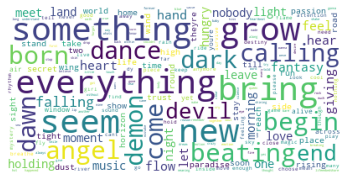

In [51]:
# visualise 100 words from the processed corpus

def word_cloud(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  

  wordcloud = WordCloud(background_color="white",max_font_size=40, relative_scaling=.5).generate(all_words)

  plt.axis("off")
  plt.imshow(wordcloud)
  


word_cloud(dictionary.values(), 100)



In [36]:
# Parameters for LDA model
chunksize = 20
passes = 20
iterations = 400
num_topics = 4 # limit to 4 different topics 


In [37]:
# train LDA model

lda_model = LdaModel(
corpus=gensim_corpus,
id2word=id2word,
chunksize=chunksize,
alpha='auto',
eta='auto',
iterations=iterations,
num_topics=num_topics,
passes=passes
)

In [ ]:
# model coherence 

coherencemodel = CoherenceModel(model=lda_model, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.3550269937285316


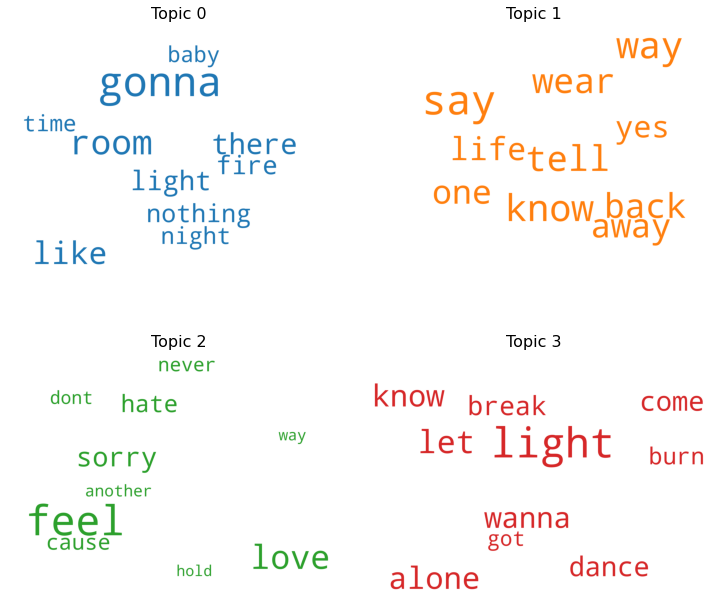

In [38]:
# 1. Wordcloud of Top 10 words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  #  get more colors from 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()